In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime
from datetime import date
from matplotlib.lines import Line2D
from scipy.integrate import simps
from scipy.signal import detrend
import scipy.stats as st
from scipy.stats import gaussian_kde
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns

import sys
sys.path.insert(0, 'D:\gitclones\marineHeatWaves')
import marineHeatWaves as mhw

In [3]:
t = np.arange(date(1982,1,1).toordinal(),date(2020,12,31).toordinal()+1)
sst = np.loadtxt("../../data/mhw/sst_NW_Atl.csv", delimiter=',', skiprows=1)
mhws, clim = mhw.detect(t, sst, pctile=90)
mhws = pd.DataFrame.from_dict(mhws)
#mhws.to_csv('../../data/mhw/mhws_NW_Atl.csv', sep = ',', index=False)
clim = pd.DataFrame.from_dict(clim)
#clim.to_csv('../../data/mhw/clim_NW_Atl.csv', sep = ',', index=False)

#df = pd.DataFrame({'duration': mhws.duration,'intensity_': mhws.intensity_max})
#df.to_csv('../../data/mhw/mhws_NW_Atl_all.csv',index=False)

#df = pd.DataFrame({'duration': mhws[pd.to_datetime(mhws.date_start) < '2015-01-01'].duration,'intensity_': mhws[pd.to_datetime(mhws.date_start) < '2015-01-01'].intensity_max})
#df.to_csv('../../data/mhw/mhw_2015_train.csv',index=False)
#df = pd.DataFrame({'duration': mhws[pd.to_datetime(mhws.date_start) >= '2015-01-01'].duration,'intensity_max': mhws[pd.to_datetime(mhws.date_start) >= '2015-01-01'].intensity_max})
#df.to_csv('../../data/mhw/mhw_2015_test.csv',index=False)

#df = pd.DataFrame({'duration': mhws[pd.to_datetime(mhws.date_start) < '2017-01-01'].duration,'intensity_': mhws[pd.to_datetime(mhws.date_start) < '2017-01-01'].intensity_max})
#df.to_csv('../../data/mhw/mhw_2017_train.csv',index=False)
#df = pd.DataFrame({'duration': mhws[pd.to_datetime(mhws.date_start) >= '2017-01-01'].duration,'intensity_max': mhws[pd.to_datetime(mhws.date_start) >= '2017-01-01'].intensity_max})
#df.to_csv('../../data/mhw/mhw_2017_test.csv',index=False)

breakpoint = 32
mhws['break'] = np.zeros(63)
for i in range(63):
    if i < breakpoint:
        mhws.iloc[i,-1] = 'before 2013-06-19'
    else:
        mhws.iloc[i,-1] = 'after 2013-06-19'

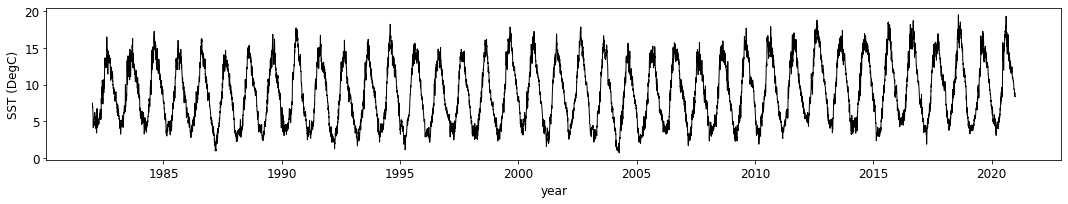

In [4]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,figsize=(15,3))
ax.plot(np.arange(date(1982,1,1),date(2021,1,1)),sst,'k',lw=1)
ax.set_xlabel('year')
ax.set_ylabel('SST (DegC)')
plt.tight_layout()
#plt.savefig('../../Dissertation_figures/sst_NW_Atl.png',dpi=300)
plt.show()

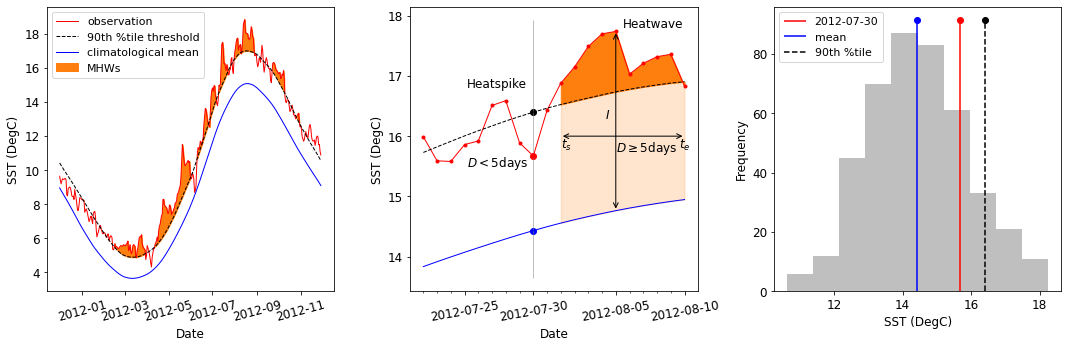

In [5]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,3,figsize=(15,5))
dates = np.arange(date(1982,1,1),date(2021,1,1))
start = 10926
ax1 = ax[0]
ax1.plot(dates[start:start+365],sst[start:start+365],'r',lw=1,label='observation')
ax1.plot(dates[start:start+365],clim.thresh[start:start+365],'k--',lw=1,label='90th %tile threshold')
ax1.plot(dates[start:start+365],clim.seas[start:start+365],'b',lw=1,label='climatological mean')
events = mhws[(mhws.date_start>np.arange(date(1982,1,1),date(2021,1,1))[start]) & (mhws.date_end<np.arange(date(1982,1,1),date(2021,1,1))[start+365])]
for i in range(events.shape[0]):
    start_date_index = np.where(dates == events.iloc[i,3])[0].item()
    end_date_index = np.where(dates == events.iloc[i,4]+datetime.timedelta(days=1))[0].item()
    if i == 0:
        label_tmp = 'MHWs'
    else:
        label_tmp = None
    ax1.fill_between(np.arange(events.iloc[i,3],events.iloc[i,4]+datetime.timedelta(days=1)),clim.thresh[start_date_index:end_date_index],sst[start_date_index:end_date_index],color='C1',label=label_tmp)
ax1.tick_params(axis='x', labelrotation = 15)
ax1.set_xlabel('Date')
ax1.set_ylabel('SST (DegC)')
ax1.legend(prop={'size': 11})

start = 11160
period = 20
ax2 = ax[1]
ax2.plot(dates[start:start+period],sst[start:start+period],'r.-',lw=1,label='observation')
ax2.plot(dates[start:start+period],clim.thresh[start:start+period],'k--',lw=1,label='90th %tile threshold')
ax2.plot(dates[start:start+period],clim.seas[start:start+period],'b',lw=1,label='climatological mean')
ax2.fill_between(dates[start+10:start+20],clim.thresh[start+10:start+20],sst[start+10:start+20],color='C1')
ax2.fill_between(dates[start+10:start+20],clim.seas[start+10:start+20],clim.thresh[start+10:start+20],color='C1',alpha=0.2)
ylim = ax2.get_ylim()
ax2.vlines(dates[start+8],ylim[0],ylim[1],ls='-',lw=0.5,colors='gray')
ax2.scatter(dates[start+8],clim.seas[start+8],color='b')
ax2.scatter(dates[start+8],clim.thresh[start+8],color='k')
ax2.scatter(dates[start+8],sst[start+8],color='r')

ax2.annotate(text='',xy=(md.date2num(dates[start+10]),16),xytext=(md.date2num(dates[start+19]),16),arrowprops=dict(arrowstyle='<->'))
ax2.annotate(text=r'$t_s$',xy=(md.date2num(dates[start+10]),15.8),fontsize=12)
ax2.annotate(text=r'$t_e$',xy=(md.date2num(dates[start+19])-0.4,15.8),fontsize=12)
ax2.annotate(text=r'$D \geq 5$days',xy=(md.date2num(dates[start+14]),15.75),fontsize=12)
ax2.annotate(text='',xy=(md.date2num(dates[start+14]),clim.seas[start+14]),xytext=(md.date2num(dates[start+14]),sst[start+14]),arrowprops=dict(arrowstyle='<->'))
ax2.annotate(text=r'$I$',xy=(md.date2num(dates[start+14])-0.8,16.3),fontsize=12)
ax2.annotate(text='Heatwave',xy=(md.date2num(dates[start+14])+0.5,17.8),fontsize=12)
ax2.annotate(text='Heatspike',xy=(md.date2num(dates[start+4])-0.8,16.8),fontsize=12)
ax2.annotate(text=r'$D < 5$days',xy=(md.date2num(dates[start+4])-0.8,15.5),fontsize=12)
ax2.tick_params(axis='x', labelrotation = 10)
ax2.xaxis.set_major_locator(md.DayLocator(bymonthday=(5,10,25,30)))
ax2.xaxis.set_minor_locator(md.DayLocator())
ax2.set_xlabel('Date')
ax2.set_ylabel('SST (DegC)')

ax3 = ax[2]
tmp = []
for i in range(dates.shape[0]):
    if (dates[i] - dates[i].astype('datetime64[M]') + 1 == 30) & (dates[i].astype('datetime64[M]').astype(int) % 12 + 1 == 7) & (i+6 < sst.shape[0]):
        for j in range(-5,6):
            tmp.append(sst[i+j])       
ax3.hist(tmp,color='gray',alpha=0.5)
ylim = ax3.get_ylim()
ax3.vlines(sst[start+8],ylim[0],ylim[1],ls='-',colors='r',label='2012-07-30')
ax3.vlines(clim.seas[start+8],ylim[0],ylim[1],ls='-',colors='b',label='mean')
ax3.vlines(clim.thresh[start+8],ylim[0],ylim[1],ls='--',colors='k',label='90th %tile')
ax3.scatter(clim.seas[start+8],ylim[1],color='b')
ax3.scatter(clim.thresh[start+8],ylim[1],color='k')
ax3.scatter(sst[start+8],ylim[1],color='r')
ax3.legend(prop={'size': 11},loc=2)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('SST (DegC)')

plt.tight_layout()
#plt.savefig('../../Dissertation_figures/MHW_definition.png',dpi=300)
plt.show()

In [193]:
mhws.date_start[32]

datetime.date(2013, 6, 19)

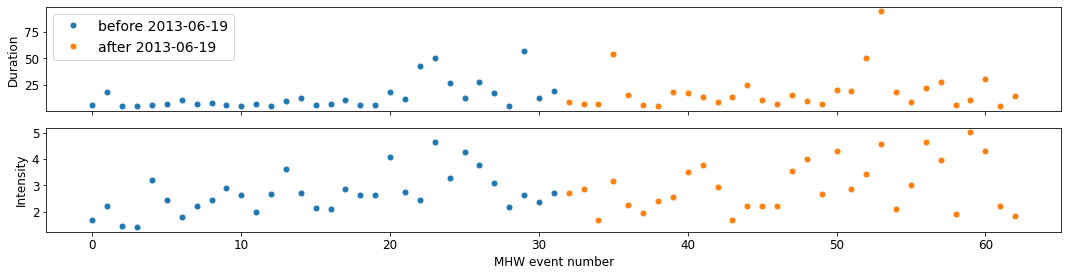

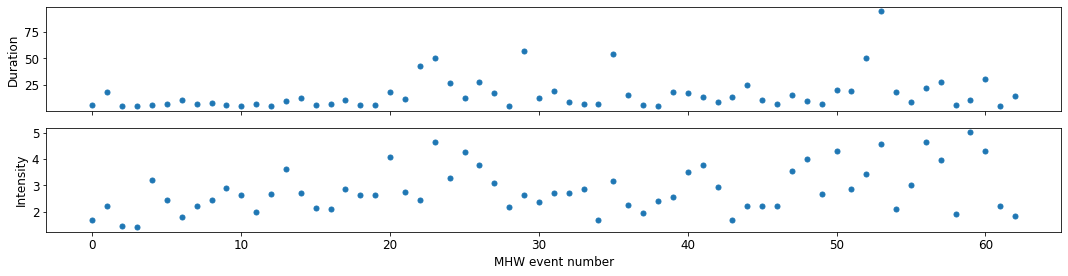

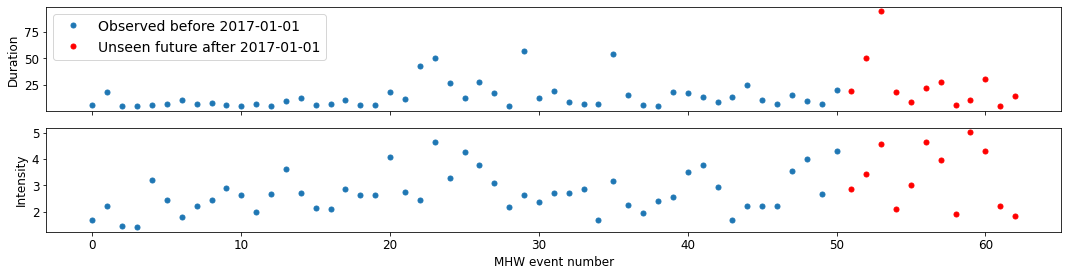

In [13]:
breakpoint = 32
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,1,figsize=[15,4])
ax[0].plot(np.arange(breakpoint),mhws.duration[:breakpoint],'.',label='before 2013-06-19',markersize=10)
ax[0].plot(np.arange(breakpoint,len(mhws)),mhws.duration[breakpoint:],'.',label='after 2013-06-19',markersize=10)
ax[0].set_ylabel('Duration')
ax[0].set_xticklabels([])
ax[0].legend(prop={'size': 14})
ax[1].plot(np.arange(breakpoint),mhws.intensity_max[:breakpoint],'.',markersize=10)
ax[1].plot(np.arange(breakpoint,len(mhws)),mhws.intensity_max[breakpoint:],'.',markersize=10)
ax[1].set_xlabel('MHW event number')
ax[1].set_ylabel('Intensity')
plt.tight_layout()
#plt.savefig('../../Dissertation_figures/duration_intensity_event_num.png',dpi=300)
plt.show()

breakpoint = 63
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,1,figsize=[15,4])
ax[0].plot(np.arange(breakpoint),mhws.duration[:breakpoint],'.',markersize=10)
ax[0].set_ylabel('Duration')
ax[0].set_xticklabels([])
ax[1].plot(np.arange(breakpoint),mhws.intensity_max[:breakpoint],'.',markersize=10)
ax[1].set_xlabel('MHW event number')
ax[1].set_ylabel('Intensity')
plt.tight_layout()
#plt.savefig('../../Dissertation_figures/all_duration_intensity_event_num.png',dpi=300)
plt.show()

breakpoint = 51
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,1,figsize=[15,4])
ax[0].plot(np.arange(breakpoint),mhws.duration[:breakpoint],'.',label='Observed before 2017-01-01',markersize=10)
ax[0].plot(np.arange(breakpoint,len(mhws)),mhws.duration[breakpoint:],'r.',label='Unseen future after 2017-01-01',markersize=10)
ax[0].set_ylabel('Duration')
ax[0].set_xticklabels([])
ax[0].legend(prop={'size': 14})
ax[1].plot(np.arange(breakpoint),mhws.intensity_max[:breakpoint],'.',markersize=10)
ax[1].plot(np.arange(breakpoint,len(mhws)),mhws.intensity_max[breakpoint:],'r.',markersize=10)
ax[1].set_xlabel('MHW event number')
ax[1].set_ylabel('Intensity')
plt.tight_layout()
plt.savefig('../../Dissertation_figures/train_test_event_num.png',dpi=300)
plt.show()

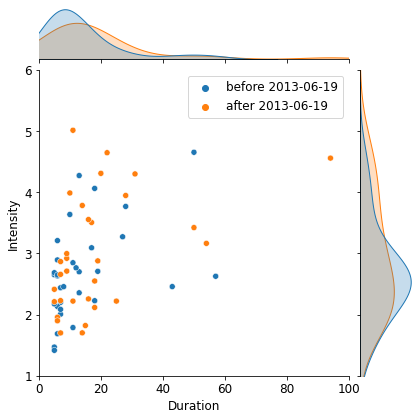

In [7]:
plt.rcParams.update({'font.size': 12})
g = sns.jointplot(data=mhws, x="duration", y="intensity_max", hue="break", xlim=[0,100], ylim=[1,6])
g.ax_joint.legend()
g.ax_joint.set_xlabel('Duration')
g.ax_joint.set_ylabel('Intensity')
#plt.savefig('../../Dissertation_figures/duration_intensity_hists_scatter2.png',dpi=300)
plt.show()

In [133]:
np.where(pd.to_datetime(mhws.date_start) < '2017-01-01')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51], dtype=int64),)

In [197]:
len(pd.to_datetime(mhws.date_peak)[endpoint:])

12

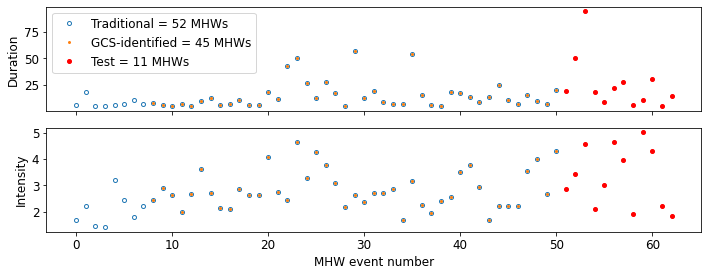

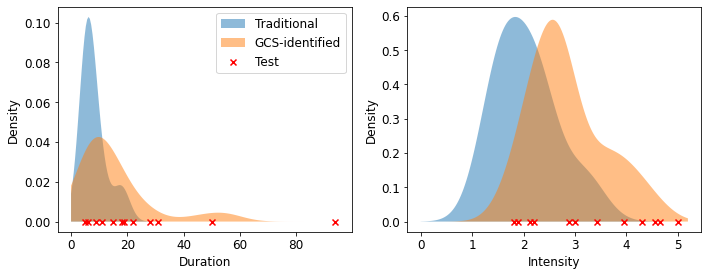

In [28]:
breakpoint = 8
endpoint = 51
fig, ax = plt.subplots(2,1,figsize=[10,4])
ax[0].plot(np.arange(endpoint),mhws.duration[:endpoint],'o',markerfacecolor='none',markersize=4,label='Traditional = 52 MHWs')
ax[0].plot(np.arange(breakpoint,endpoint),mhws.duration[breakpoint:endpoint],'o',markeredgecolor='none',markerfacecolor='C1',markersize=3,label='GCS-identified = 45 MHWs')
ax[0].plot(np.arange(endpoint,len(mhws)),mhws.duration[endpoint:],'ro',markersize=4,label='Test = 11 MHWs')
ax[0].set_ylabel('Duration')
ax[0].set_xticklabels([])
ax[0].legend()
ax[1].plot(np.arange(endpoint),mhws.intensity_max[:endpoint],'o',markerfacecolor='none',markersize=4)
ax[1].plot(np.arange(breakpoint,endpoint),mhws.intensity_max[breakpoint:endpoint],'o',markeredgecolor='none',markerfacecolor='C1',markersize=3)
ax[1].plot(np.arange(endpoint,len(mhws)),mhws.intensity_max[endpoint:],'ro',markersize=4)
ax[1].set_ylabel('Intensity')
ax[1].set_xlabel('MHW event number')
plt.tight_layout()
plt.savefig('../../Dissertation_figures/CCA_timeseries.png',dpi=300)
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,4))
density = gaussian_kde(mhws.duration[:breakpoint])
xs = np.linspace(0,95,200)
ax[0].fill_between(xs,density(xs),alpha=0.5,label='Traditional')
density = gaussian_kde(mhws.duration[breakpoint:endpoint])
ax[0].fill_between(xs,density(xs),alpha=0.5,label='GCS-identified')
ax[0].scatter(mhws.duration[endpoint:],np.zeros_like(mhws.duration[endpoint:]),marker='x',color='r',clip_on=False,label='Test')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Density')
ax[0].legend()
density = gaussian_kde(mhws.intensity_max[:breakpoint])
xs = np.linspace(0,5.2,200)
ax[1].fill_between(xs,density(xs),alpha=0.5)
density = gaussian_kde(mhws.intensity_max[breakpoint:endpoint])
xs = np.linspace(0,5.2,200)
ax[1].fill_between(xs,density(xs),alpha=0.5)
ax[1].scatter(mhws.intensity_max[endpoint:],np.zeros_like(mhws.intensity_max[endpoint:]),marker='x',color='r',clip_on=False)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Density')
plt.tight_layout()
plt.savefig('../../Dissertation_figures/CCA_marginals.png',dpi=300)
plt.show()

Fitting 10 distributions: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.28it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
powerlaw,8.762662,654.535011,-7.517454,inf,0.340113,0.014412
chi2,9.100667,854.216443,-6.760495,inf,0.355139,0.009203
gamma,9.313114,1026.805416,-6.298979,inf,0.492716,0.000053
exponpow,9.509639,634.551822,-5.881331,inf,0.264572,0.100355
lognorm,9.596618,952.636882,-5.699235,inf,0.476706,0.000107


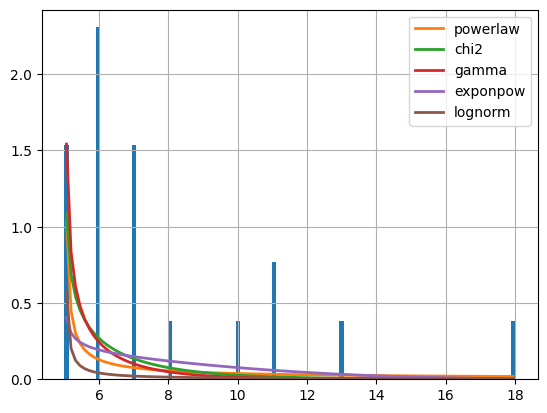

In [174]:
f = Fitter(mhws.duration[:20],distributions= get_common_distributions())
f.fit()
f.summary()

Fitting 10 distributions: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.65it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,14.039872,323.210864,-82.148303,inf,0.057288,0.978398
gamma,14.074902,318.577434,-81.991313,inf,0.060740,0.963249
chi2,14.074902,318.577076,-81.991310,inf,0.060742,0.963241
rayleigh,14.285904,311.229596,-85.196999,inf,0.092001,0.627019
cauchy,14.391101,392.333533,-84.734787,inf,0.121419,0.287110


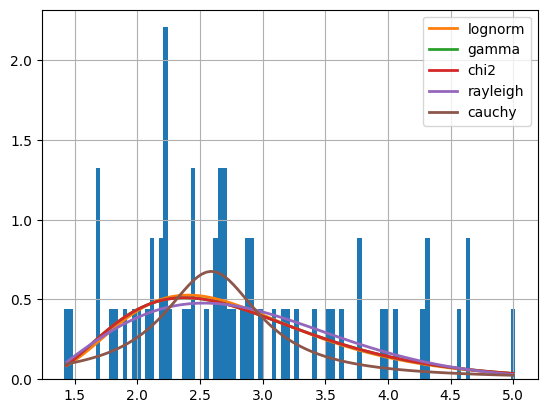

In [170]:
f = Fitter(mhws.intensity_max,distributions= get_common_distributions())
f.fit()
f.summary()

In [58]:
years = [1995,2000,2005,2010,2015]
for i in range(len(years)):
    time_condition = pd.to_datetime(mhws_WA.date_start) < f'{years[i]}-01-01'
    df = pd.DataFrame({'duration': mhws_WA[time_condition].duration,'intensity_': mhws_WA[time_condition].intensity_max})
    df.to_csv(f'../../data/mhw/mhws70_WA_{i}_train.csv',index=False)
    if i < len(years)-1:
        time_condition = (pd.to_datetime(mhws_WA.date_start) >= f'{years[i]}-01-01') & (pd.to_datetime(mhws_WA.date_start) < f'{years[i+1]}-01-01')
        df = pd.DataFrame({'duration': mhws_WA[time_condition].duration,'intensity_max': mhws_WA[time_condition].intensity_max})
        df.to_csv(f'../../data/mhw/mhws70_WA_{i}_test.csv',index=False)
    else:
        time_condition = pd.to_datetime(mhws_WA.date_start) >= f'{years[i]}-01-01'
        df = pd.DataFrame({'duration': mhws_WA[time_condition].duration,'intensity_max': mhws_WA[time_condition].intensity_max})
        df.to_csv(f'../../data/mhw/mhws70_WA_{i}_test.csv',index=False)

In [55]:
i

4